<a href="https://colab.research.google.com/github/soburyusuf/clarias-gariepinus-growth-prediction-app/blob/main/Predicting_Final_Mean_Weight_of_Clarias_Fish_Based_on_Feed_Composition_and_Growth_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/soburyusuf/clarias-gariepinus-growth-prediction-app.git

fatal: destination path 'clarias-gariepinus-growth-prediction-app' already exists and is not an empty directory.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib



In [6]:
url='/content/clarias-gariepinus-growth-prediction-app/Clarias growth perfomance.xlsx'
df = pd.read_excel(url)
df.head()

,Initial Mean Weight (g),Final Mean Weight (g),Mean Weight gained(g),Specific Growth Rate (SGR),Feed Conversion Rate (FCR),Percentage Mortality (%PM),Percentage Survival (%PS),Single Cell Protein,Single Cell Protein Type (SPT),SPT Percentage,Commercial Feed Percentage
0,2.2,6.22,4.02,5.6,0.43,60.0,40.0,Yes,Citrus sinesis Peel,0.1,0.9
1,2.1,5.87,4.77,5.6,0.33,70.0,30.0,Yes,Citrus sinesis Peel,0.2,0.8
2,2.2,5.89,3.69,5.4,0.36,60.0,40.0,Yes,Citrus sinesis Peel,0.3,0.7
3,2.1,4.54,2.44,4.2,0.34,55.0,45.0,Yes,Citrus sinesis Pulp,0.1,0.9
4,2.2,6.34,4.14,5.8,0.32,50.0,50.0,Yes,Citrus sinesis Pulp,0.2,0.8


In [7]:
# Original features and target
X = df[['Initial Mean Weight (g)', 'SPT Percentage', 'Commercial Feed Percentage']]
categorical_cols = ['Single Cell Protein', 'Single Cell Protein Type (SPT)']


In [8]:
# One-hot encode categorical features on original data
X_encoded = pd.get_dummies(df[categorical_cols])  # Encoding categorical features
X_numeric = X.reset_index(drop=True) # Resets index of numerical features


In [9]:
# Combine numeric and encoded categorical features for training
X_full = pd.concat([X_numeric, X_encoded.reset_index(drop=True)], axis=1) # Concatenates numerical and encoded features
y = df['Final Mean Weight (g)'] # Defines the target variable
# Number of synthetic samples to generate
n_synthetic = 100



In [10]:
# Step 1: Generate synthetic numeric features by adding Gaussian noise
numeric_means = X_numeric.mean()
numeric_stds = X_numeric.std()
synthetic_numeric = np.random.normal(loc=numeric_means, scale=numeric_stds, size=(n_synthetic, X_numeric.shape[1]))
synthetic_numeric_df = pd.DataFrame(synthetic_numeric, columns=X_numeric.columns)


In [11]:
# Step 2: Sample synthetic categorical features by sampling original categorical rows
synthetic_categorical_df = df[categorical_cols].sample(n=n_synthetic, replace=True).reset_index(drop=True)


In [12]:
# Step 3: Combine synthetic numeric and categorical raw features
synthetic_raw_df = pd.concat([synthetic_numeric_df, synthetic_categorical_df], axis=1)


In [13]:
# Step 4: Apply same one-hot encoding to synthetic categorical features, but limit to original categories
synthetic_encoded = pd.get_dummies(synthetic_raw_df[categorical_cols])
# Get the columns present in the original encoded data
original_encoded_cols = X_encoded.columns
# Keep only the original encoded columns in the synthetic data, fill missing with 0
synthetic_encoded = synthetic_encoded.reindex(columns=original_encoded_cols, fill_value=0)


In [14]:
# Step 5: Combine synthetic numeric and encoded categorical features
synthetic_processed = pd.concat([synthetic_raw_df[X_numeric.columns], synthetic_encoded], axis=1)


In [15]:
# Step 6: Align synthetic features to training features (same columns and order), fill missing columns with 0
synthetic_processed = synthetic_processed.reindex(columns=X_full.columns, fill_value=0)


In [16]:
# Initialize and train the model (you need to do this before predicting)
model = LinearRegression()
model.fit(X_full, y)  # Training the model


LinearRegression()

In [17]:
# Step 7: Predict synthetic targets using your trained model
synthetic_targets = model.predict(synthetic_processed)


In [18]:
# Step 8: Combine synthetic data with original data for augmented training set
X_augmented = pd.concat([X_full, synthetic_processed], ignore_index=True)
y_augmented = pd.concat([y, pd.Series(synthetic_targets)], ignore_index=True)


In [19]:
# Now you can retrain your model on (X_augmented, y_augmented)
model.fit(X_augmented, y_augmented)

LinearRegression()

In [20]:
X_augmented.shape

(115, 10)

In [21]:
from sklearn.model_selection import train_test_split
# Split the augmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Now you can train your model on (X_train, y_train) and evaluate on (X_test, y_test)
model.fit(X_train, y_train)


LinearRegression()

In [22]:
y_pred = model.predict(X_test)

In [23]:
print(y_pred)

[ 4.72578212  5.43467636  1.54378514 10.11432618 11.6511668   2.94718769
  1.88817295  3.17935808  2.6703818   4.76202428 10.22326382  6.28913452
  5.10880248 14.1808823   5.39839566  6.99132876  6.80388975  3.59389429
  2.44018944  2.77622177  1.8041857   5.99315078  4.26195621]


In [24]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 2.7365658412409153
R2: 0.6794583899661335


In [25]:
# Test the model
predicted =model.predict(X_test)

In [26]:
expected = y_test

In [27]:
for p,e in zip(predicted[::5], expected[::5]):
    print(f'predicted: {p:.2f}, expected: {e:.2f}')

predicted: 4.73, expected: 4.72
predicted: 2.95, expected: 3.05
predicted: 10.22, expected: 9.80
predicted: 6.99, expected: 6.22
predicted: 1.80, expected: 1.59


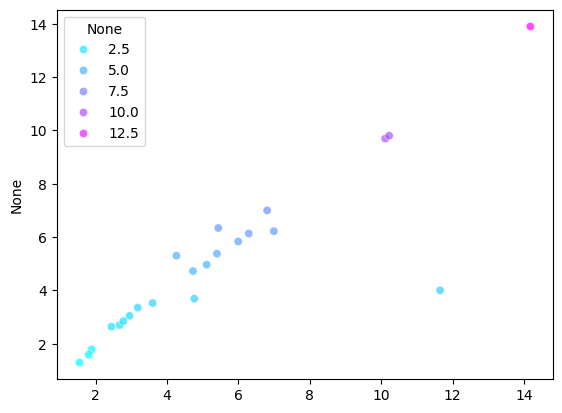

In [28]:
axes= sns.scatterplot(x=predicted, y=expected, hue=expected, palette='cool', alpha=.7)

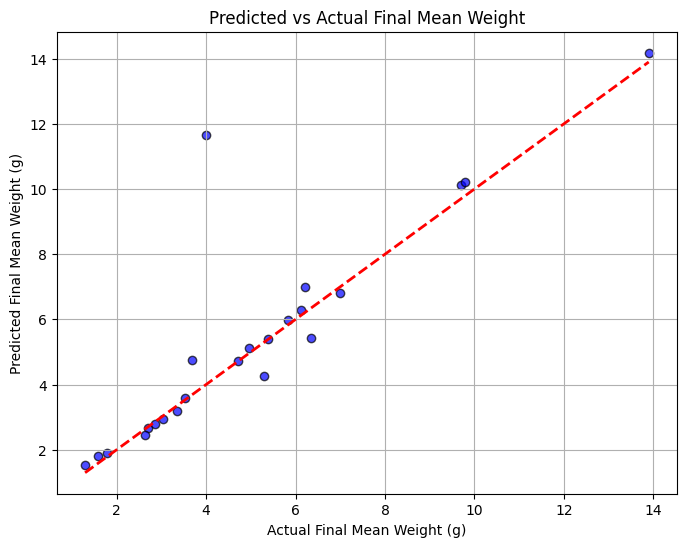

In [29]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your actual and predicted values respectively
# Example:
# y_test = [6.80, 15.36, 2.21, 6.22, 10.74]
# y_pred = [6.59, 15.60, 2.27, 6.99, 10.99]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Final Mean Weight (g)')
plt.ylabel('Predicted Final Mean Weight (g)')
plt.title('Predicted vs Actual Final Mean Weight')
plt.grid(True)
plt.show()


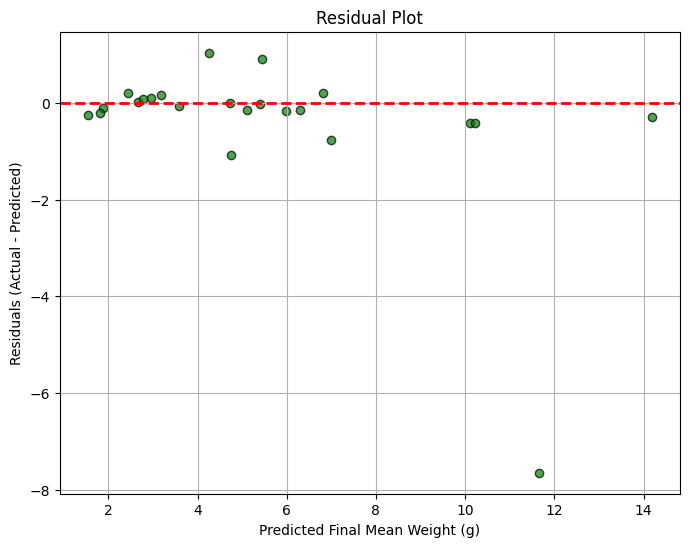

In [30]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='green', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Final Mean Weight (g)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


In [36]:
import joblib
# save the trained model
joblib.dump(model, 'clarias_growth_prediction_model.pkl')

['clarias_growth_prediction_model.pkl']

In [37]:
joblib.dump(model, 'clarias_growth_prediction_model.pkl')

['clarias_growth_prediction_model.pkl']